In [1]:
# Install required library
!pip install swifter
!pip install kagglehub

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("paramaggarwal/fashion-product-images-dataset")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/paramaggarwal/fashion-product-images-dataset/versions/1


In [3]:
import os

# Verify files in the dataset directory
dataset_path = '/root/.cache/kagglehub/datasets/paramaggarwal/fashion-product-images-dataset/versions/1/fashion-dataset'
print("Files in dataset directory:", os.listdir(dataset_path))

Files in dataset directory: ['styles.csv', 'images', 'styles', 'images.csv', 'fashion-dataset']


In [4]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn
import torchvision
from torchvision import models, transforms
import cv2
import joblib
import torch.nn.functional as F
from sklearn.metrics.pairwise import cosine_similarity
import swifter
from PIL import Image
from torch.autograd import Variable
import warnings
warnings.filterwarnings("ignore")

In [5]:
# Load dataset
fashion_data = pd.read_csv('/root/.cache/kagglehub/datasets/paramaggarwal/fashion-product-images-dataset/versions/1/fashion-dataset/styles.csv', on_bad_lines='skip')

In [6]:
# Add image path column
fashion_data['image_path'] = fashion_data.apply(lambda row: str(row['id']) + '.jpg', axis=1)
fashion_data = fashion_data.reset_index(drop=True)

In [7]:
# Define image path functions
def get_image_path(image_name):
    base_path = "/root/.cache/kagglehub/datasets/paramaggarwal/fashion-product-images-dataset/versions/1/fashion-dataset/images/"
    return base_path + image_name

def load_image(image_name):
    return cv2.imread(get_image_path(image_name))

In [8]:
# Display images in a grid format
def display_images(image_dict, rows=1, cols=1, figsize=(12, 12)):
    fig, axes = plt.subplots(ncols=cols, nrows=rows, figsize=figsize)
    for idx, name in enumerate(image_dict):
        axes.ravel()[idx].imshow(cv2.cvtColor(image_dict[name], cv2.COLOR_BGR2RGB))
        axes.ravel()[idx].set_title(name)
        axes.ravel()[idx].set_axis_off()
    plt.tight_layout()

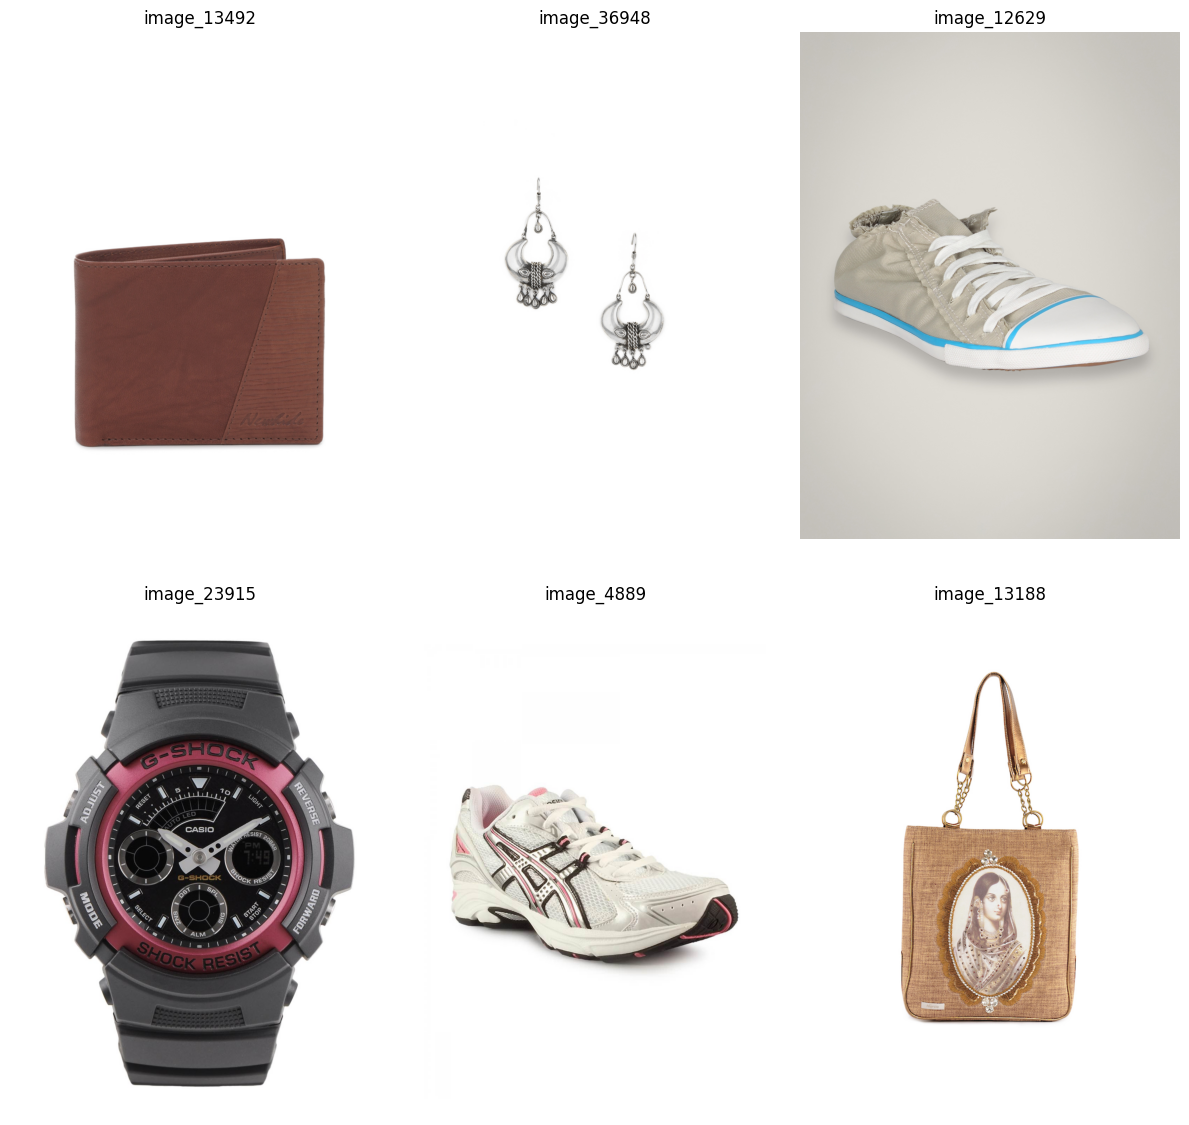

In [9]:
# Sample display
sample_images = {'image_' + str(i): load_image(row.image_path) for i, row in fashion_data.sample(6).iterrows()}
display_images(sample_images, 2, 3)

In [10]:
# Set up models
resnet_model = models.resnet50(pretrained=True)
vgg_model = models.vgg16(pretrained=True)
inception_v3_model = models.inception_v3(pretrained=True)

In [11]:
# Set layers for feature extraction
resnet_layer = resnet_model._modules.get('avgpool')
vgg_layer = vgg_model._modules.get('avgpool')
inception_v3_layer = inception_v3_model._modules.get('avgpool')

In [12]:
# Image transformations
resize_transform = transforms.Resize((224, 224))
normalize_transform = transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
to_tensor_transform = transforms.ToTensor()

In [17]:
# Define a function to extract hybrid embeddings from an image
def extract_hybrid_embeddings(image_name):
    try:
        # Load and preprocess the image with resizing for Inception
        img = Image.open(get_image_path(image_name)).convert('RGB')

        # Adjust transformation for InceptionV3 (299x299)
        img_transformed = Variable(normalize_transform(to_tensor_transform(img.resize((299, 299)))).unsqueeze(0))

        # Initialize storage tensors for embeddings
        resnet_emb = torch.zeros(2048)
        vgg_emb = torch.zeros(25088)
        inception_v3_emb = torch.zeros(2048)

        # Set models to evaluation mode
        resnet_model.eval()
        vgg_model.eval()
        inception_v3_model.eval()

        # Extract ResNet embeddings
        def resnet_hook(module, input, output):
            resnet_emb.copy_(output.data.view(-1))
        resnet_hook_layer = resnet_layer.register_forward_hook(resnet_hook)
        resnet_model(img_transformed)
        resnet_hook_layer.remove()

        # Extract VGG embeddings with flattening
        def vgg_hook(module, input, output):
            vgg_emb.copy_(output.data.view(-1))
        vgg_hook_layer = vgg_layer.register_forward_hook(vgg_hook)
        vgg_model(img_transformed)
        vgg_hook_layer.remove()

        # Extract Inception embeddings with resized input
        def inception_v3_hook(module, input, output):
            inception_v3_emb.copy_(output.data.view(-1))
        inception_v3_hook_layer = inception_v3_layer.register_forward_hook(inception_v3_hook)
        inception_v3_model(img_transformed)
        inception_v3_hook_layer.remove()

        # Concatenate embeddings for hybrid features
        return torch.cat([resnet_emb, vgg_emb, inception_v3_emb])

    except FileNotFoundError:
        missing_index = fashion_data[fashion_data['image_path'] == image_name].index
        missing_images.append(missing_index)

In [18]:
# Test hybrid embedding extraction on a sample image
embedding_sample = extract_hybrid_embeddings(fashion_data.iloc[0].image_path)

In [19]:
# Compute cosine similarity
cos_similarity = nn.CosineSimilarity(dim=1, eps=1e-6)
cos_sim_result = cos_similarity(embedding_sample.unsqueeze(0), embedding_sample.unsqueeze(0))
print('Cosine Similarity:', cos_sim_result)

Cosine Similarity: tensor([1.])


In [21]:
# Process subset of images for embedding calculation
fashion_data_subset = fashion_data[:5000]
fashion_embeddings = fashion_data_subset['image_path'].swifter.apply(lambda img: extract_hybrid_embeddings(img))

Pandas Apply:   0%|          | 0/5000 [00:00<?, ?it/s]

In [22]:
# Convert embeddings to DataFrame and save
embedding_df = fashion_embeddings.apply(pd.Series)
embedding_df.to_csv('fashion_embeddings.csv')

In [23]:
# Load embeddings and save as pickle
embedding_df = pd.read_csv('fashion_embeddings.csv')
embedding_df.drop(['Unnamed: 0'], axis=1, inplace=True)
embedding_df.dropna(inplace=True)
joblib.dump(embedding_df, 'fashion_embeddings.pkl')

['fashion_embeddings.pkl']

In [24]:
# Load embeddings for recommendation
loaded_embeddings = joblib.load('./fashion_embeddings.pkl')
similarity_matrix = cosine_similarity(loaded_embeddings)

In [25]:
# Index mapping for recommendations
index_mapping = pd.Series(range(len(fashion_data)), index=fashion_data.index)

In [26]:
# Recommendation function
def get_similar_images(image_index, data, top_n=6):
    sim_index = index_mapping[image_index]
    similarity_scores = list(enumerate(similarity_matrix[sim_index]))
    similarity_scores = sorted(similarity_scores, key=lambda x: x[1], reverse=True)[1:top_n+1]
    recommended_indices = [i[0] for i in similarity_scores]
    similarity_values = [i[1] for i in similarity_scores]
    return index_mapping.iloc[recommended_indices].index, similarity_values

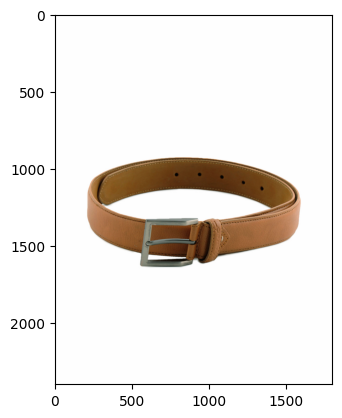

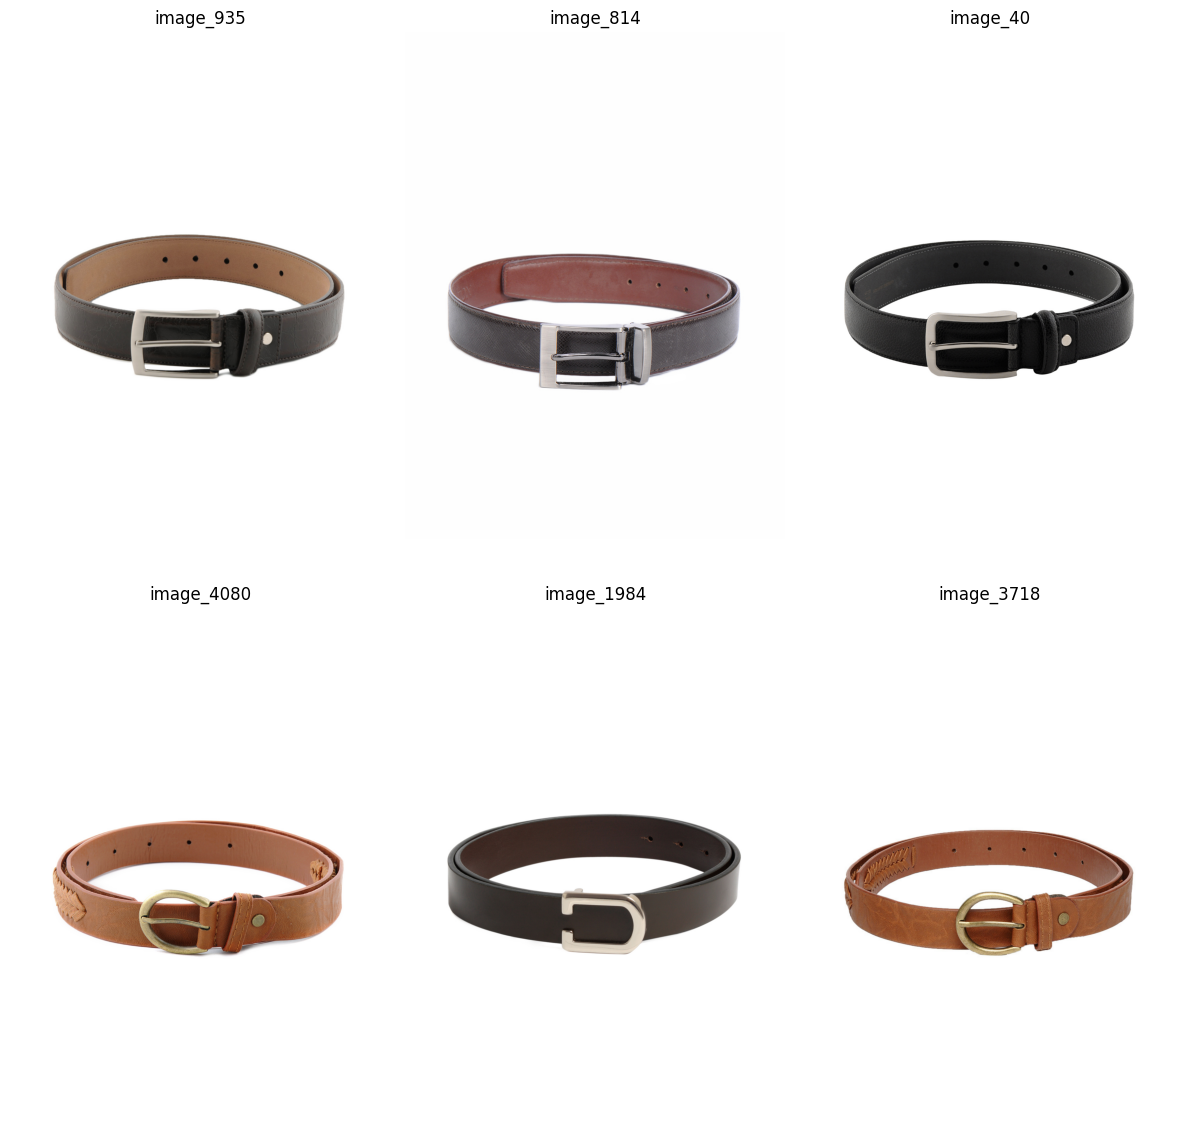

In [27]:
# Visualize recommendations
def visualize_recommendations(image_index):
    rec_indices, rec_similarities = get_similar_images(image_index, fashion_data, top_n=6)
    plt.imshow(cv2.cvtColor(load_image(fashion_data.iloc[image_index].image_path), cv2.COLOR_BGR2RGB))
    recommended_images = {'image_' + str(i): load_image(row.image_path) for i, row in fashion_data.loc[rec_indices].iterrows()}
    display_images(recommended_images, 2, 3)

# Example usage
visualize_recommendations(177)

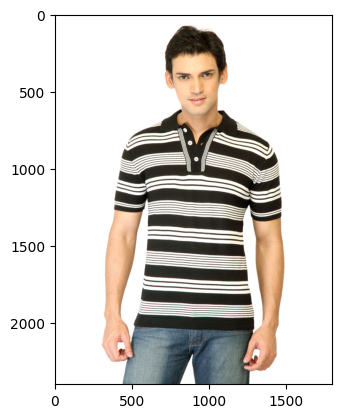

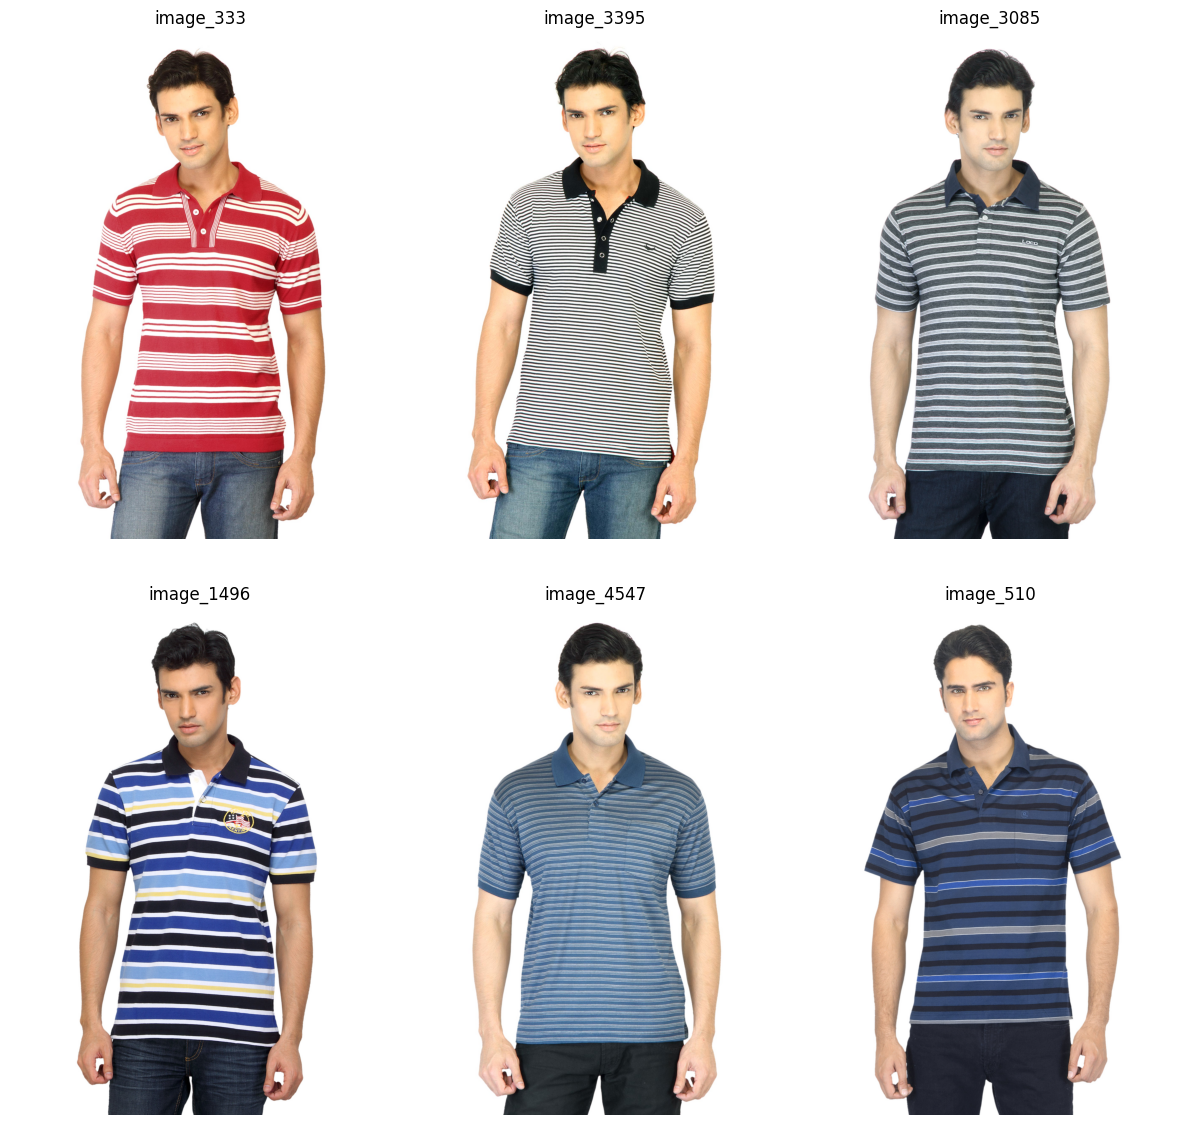

In [28]:
# Visualize recommendations
def visualize_recommendations(image_index):
    rec_indices, rec_similarities = get_similar_images(image_index, fashion_data, top_n=6)
    plt.imshow(cv2.cvtColor(load_image(fashion_data.iloc[image_index].image_path), cv2.COLOR_BGR2RGB))
    recommended_images = {'image_' + str(i): load_image(row.image_path) for i, row in fashion_data.loc[rec_indices].iterrows()}
    display_images(recommended_images, 2, 3)

# Example usage
visualize_recommendations(500)